In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import json
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
import numpy as np
import ast

# Reading in and preprocess the data by deleting useless columns and converting coded strings to ints

df = pd.read_csv('youtube1000.csv')

df = df.drop(columns=['contentDetails.dimension', 'contentDetails.projection','etag', 'id',
                     'kind','snippet.channelId', 'snippet.thumbnails.default.height',
                     'snippet.thumbnails.default.url', 'snippet.thumbnails.default.width',
                     'snippet.thumbnails.high.height', 'snippet.thumbnails.high.url',
                     'snippet.thumbnails.high.width', 'snippet.thumbnails.maxres.height',
                     'snippet.thumbnails.maxres.url', 'snippet.thumbnails.maxres.width',
                     'snippet.thumbnails.medium.height', 'snippet.thumbnails.medium.url',
                     'snippet.thumbnails.medium.width', 'snippet.thumbnails.standard.height',
                     'snippet.thumbnails.standard.url', 'snippet.thumbnails.standard.width',
                      'snippet.defaultAudioLanguage', 'snippet.defaultLanguage',
                      'snippet.liveBroadcastContent', 'snippet.title', 'Unnamed: 0', 
                      'snippet.localized.description', 'snippet.localized.title',
                      'snippet.description', 'snippet.channelTitle', 'statistics.favoriteCount'
                     ])


df=df.rename(columns = {'statistics.dislikeCount':'dislikeCount'})
df=df.rename(columns = {'statistics.commentCount':'commentCount'})
df=df.rename(columns = {'statistics.likeCount':'likeCount'})
df=df.rename(columns = {'statistics.viewCount':'viewCount'})
df=df.rename(columns = {'snippet.categoryId':'catID'})
df=df.rename(columns = {'contentDetails.licensedContent':'licensed'})



print(df.shape)
print(df.columns)
print(df.describe())



(1000, 12)
Index(['search_word', 'contentDetails.caption', 'contentDetails.definition',
       'contentDetails.duration', 'licensed', 'catID', 'snippet.publishedAt',
       'snippet.tags', 'commentCount', 'dislikeCount', 'likeCount',
       'viewCount'],
      dtype='object')
             catID   commentCount  dislikeCount     likeCount     viewCount
count  1000.000000     963.000000  9.900000e+02  9.900000e+02  9.970000e+02
mean     20.248000   11468.477674  8.526747e+03  1.502547e+05  1.576084e+07
std       6.927517   53501.023334  5.519503e+04  7.402962e+05  9.327645e+07
min       1.000000       0.000000  0.000000e+00  0.000000e+00  4.800000e+01
25%      17.000000      89.500000  2.700000e+01  5.800000e+02  3.003100e+04
50%      22.000000     549.000000  2.055000e+02  3.794000e+03  2.345960e+05
75%      25.000000    2981.000000  1.732000e+03  2.818075e+04  2.433079e+06
max      30.000000  691263.000000  1.242881e+06  9.982215e+06  1.554095e+09


In [2]:
# Address Null values. Utilized mean value to address missing continuous data
# Convert and drop snippet.tags, date columns.   

df['commentCount'].fillna((df['commentCount'].mean()), inplace=True)
df['dislikeCount'].fillna((df['dislikeCount'].mean()), inplace=True)
df['likeCount'].fillna((df['likeCount'].mean()), inplace=True)
df['viewCount'].fillna((df['viewCount'].mean()), inplace=True)
df['snippet.tags'].fillna('[]', inplace=True)

#Convert snippet.tags into length for continuous data
df['tags_length'] = [len(ast.literal_eval(row)) for row in df['snippet.tags']]
df = df.drop(columns=['snippet.tags'])

# Bucketize the dependent variable / viewCount
df['view_bucket'] = pd.cut(df['viewCount'], [0,50000,100000,150000,200000,250000,300000,350000,400000,450000,500000,10000000000000], 
                           include_lowest=True, labels=["1", "2", "3","4","5","6","7",
                                                       "8","9","10","11"])
df['view_bucket'] = df['view_bucket'].astype(float)
df = df.drop(columns=['viewCount'])

#Converts published date into date time object and sort df by date

df['date'] =  pd.to_datetime(df['snippet.publishedAt'], format='%Y-%m-%dT%H:%M:%S.000Z', utc=True)
df.sort_values(by='date')

df = df.drop(columns=['snippet.publishedAt'])

# Converts all durations into a standard unit of seconds
s = df['contentDetails.duration']
multiplication = [3600, 60, 1, 60, 1, 60, 1]
test_list = []
for item in s:
    r = re.search(r'(\d*)H(\d*)M(\d*)S|(\d*)M(\d*)S|(\d*)M|(\d*)S', item, re.I)
    resp = list(r.groups(0)) 
    resp = [int(num) for num in resp]
    test = sum([item*time_duration for item, time_duration in zip(resp, multiplication)])
    test_list.append(test)
df['duration'] = test_list    

# Drop off the original duration column since it is now not required 
df = df.drop(columns=['contentDetails.duration'])
    

df.info()
df.head()

%store df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
search_word                  1000 non-null object
contentDetails.caption       1000 non-null bool
contentDetails.definition    1000 non-null object
licensed                     1000 non-null bool
catID                        1000 non-null int64
commentCount                 1000 non-null float64
dislikeCount                 1000 non-null float64
likeCount                    1000 non-null float64
tags_length                  1000 non-null int64
view_bucket                  1000 non-null float64
date                         1000 non-null datetime64[ns, UTC]
duration                     1000 non-null int64
dtypes: bool(2), datetime64[ns, UTC](1), float64(4), int64(3), object(2)
memory usage: 80.2+ KB
Stored 'df' (DataFrame)


There does not appear to be a linear or any relationship  between publish date and views.
For simplicity purposes, I will not consider publish date in the model


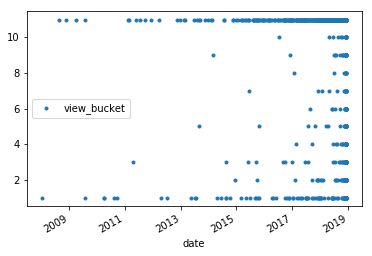

In [3]:

#plt.title('Published date vs. view_bucket')
df.plot(x='date', y='view_bucket', style=".")
print('There does not appear to be a linear or any relationship  between publish date and views.')
print('For simplicity purposes, I will not consider publish date in the model')

Average length of a video in seconds 1377.266


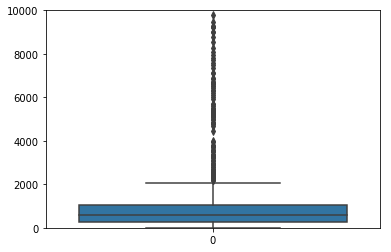

In [4]:
sns.boxplot(data=df['duration'])
plt.ylim(0, 10000)
print('Average length of a video in seconds ' + str(df['duration'].mean()))



There does not appear to be strong relationship of video duration with view count


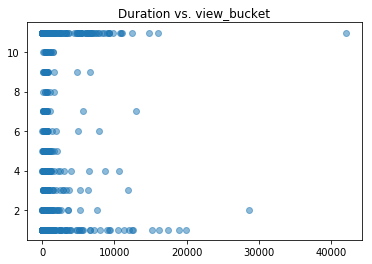

In [5]:

plt.scatter(df['duration'], df['view_bucket'], alpha=0.5)
plt.title('Duration vs. view_bucket')
print('There does not appear to be relationship between video duration and view count')

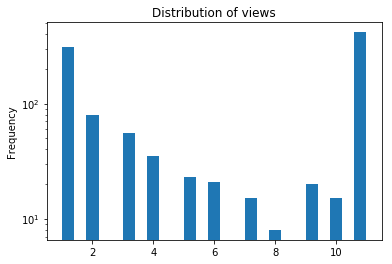

Average view_bucket for all 1000 videos 6.11
Observation: Looks like an inverse normal distribution


In [6]:
# Distribution of views.  Most frequency appears in under 200,000 views
df['view_bucket'].plot.hist(bins =25)
plt.title('Distribution of views')
plt.yscale('log')
plt.xscale('linear')
plt.show()

print('Average view_bucket for all 1000 videos ' + str(round(df['view_bucket'].mean(),2)))
print('Observation: Looks like an inverse normal distribution')





[None]

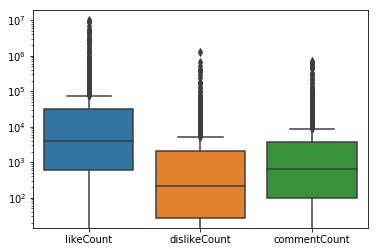

In [7]:
#Univariate Analysis - boxplot shows likeCounts tends to be higher
stats_df = df[['likeCount', 'dislikeCount', 'commentCount']].copy()
ax = sns.boxplot(data=stats_df)
ax.set(yscale="log")

Licensed content does not have relationship w/ views
   licensed  view_bucket
0     False            5
1      True            6
    index     search_word  view_bucket
4       4    dude perfect           10
14     14           music           10
13     13          movies            9
18     18        vacation            7
1       1            cats            7
2       2       christmas            6
5       5          gaming            6
15     15          python            6
12     12       minecraft            6
8       8          iphone            5
7       7          horror            5
9       9           laugh            5
11     11            mars            5
17     17          sports            5
10     10             mac            4
3       3    donald trump            4
16     16        speedrun            4
19     19  video blogging            3
6       6            golf            2
0       0         Siemens            2
    index  catID  view_bucket
15     15     30       

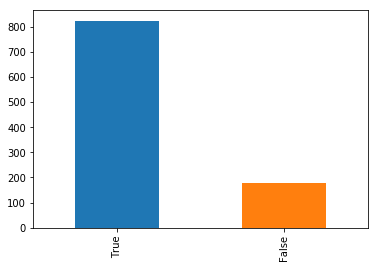

In [8]:
# Analysis of average view count based on licensed content and also search_word
print('Licensed content does not have relationship w/ views') 
df['licensed'].value_counts().plot(kind='bar')

pd.set_option('display.float_format', lambda x: '%i' % x)
print(df.groupby('licensed', as_index=False)['view_bucket'].mean())
grouped_search = df.groupby('search_word', as_index=False)['view_bucket'].mean().reset_index()
print(grouped_search.sort_values('view_bucket', ascending=False))

grouped_id = df.groupby('catID', as_index=False)['view_bucket'].mean().reset_index()
print(grouped_id.sort_values('view_bucket', ascending=False))

print('Search word and video category have strong relationship w/ views ')

# most categoryID views - music, Sports, Pets and Animals


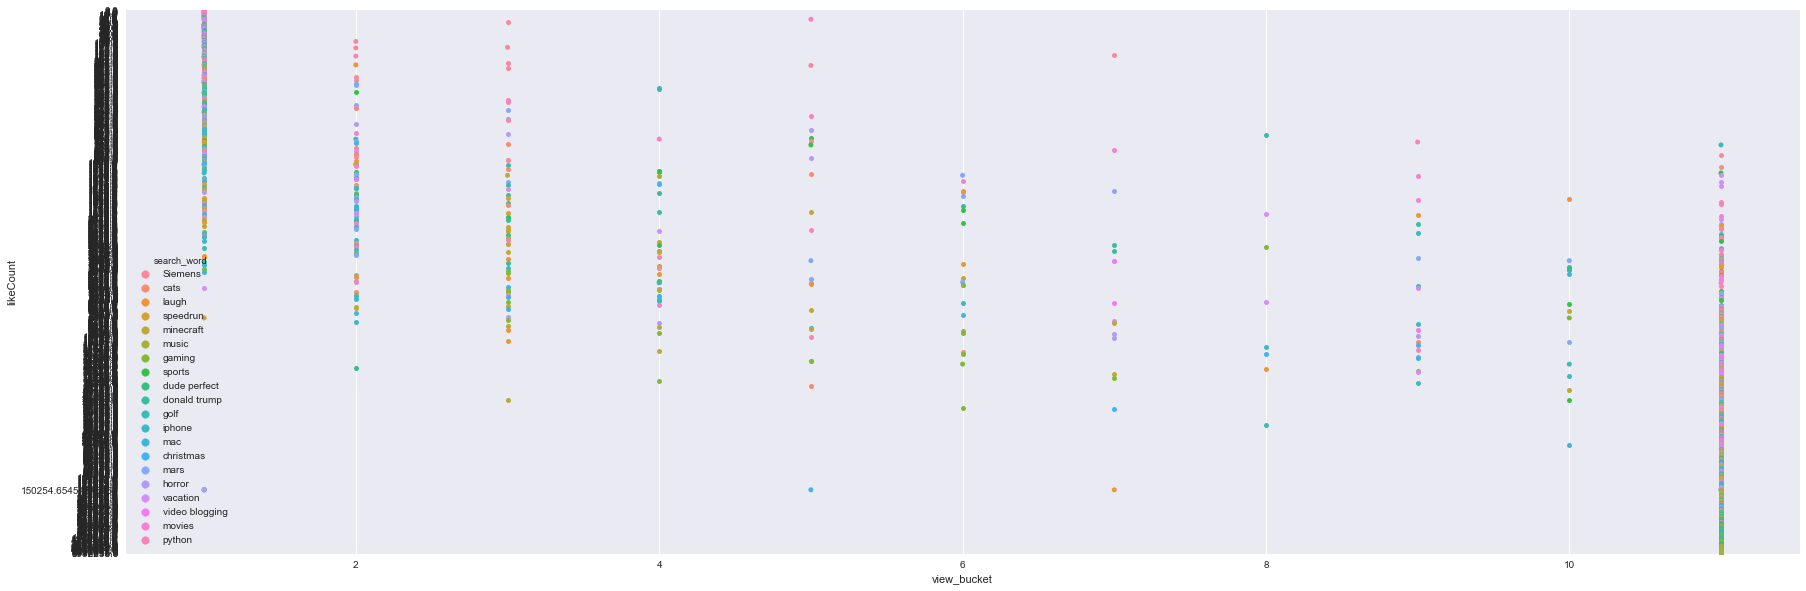

In [9]:
# Bi-variate Analysis


#sns.lmplot(x='statistics.likeCount', y='statistics.viewCount', data=df, hue='search_word', palette='Set1')


sns.set(rc={'figure.figsize':(30,10)})
sns.swarmplot(x='view_bucket',y='likeCount', data=df, hue='search_word', orient='h')

      


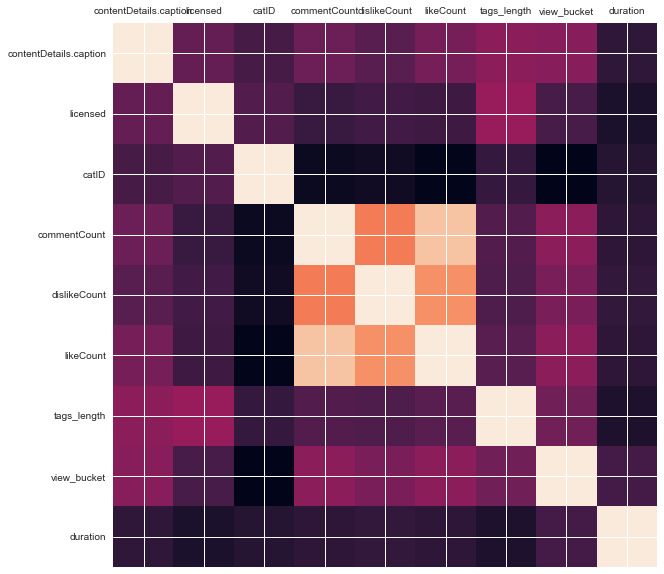

In [10]:


def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
plot_corr(df)

Spearmans correlation coefficient: 0.852
LikeCount and views are correlated (reject H0) p=0.000


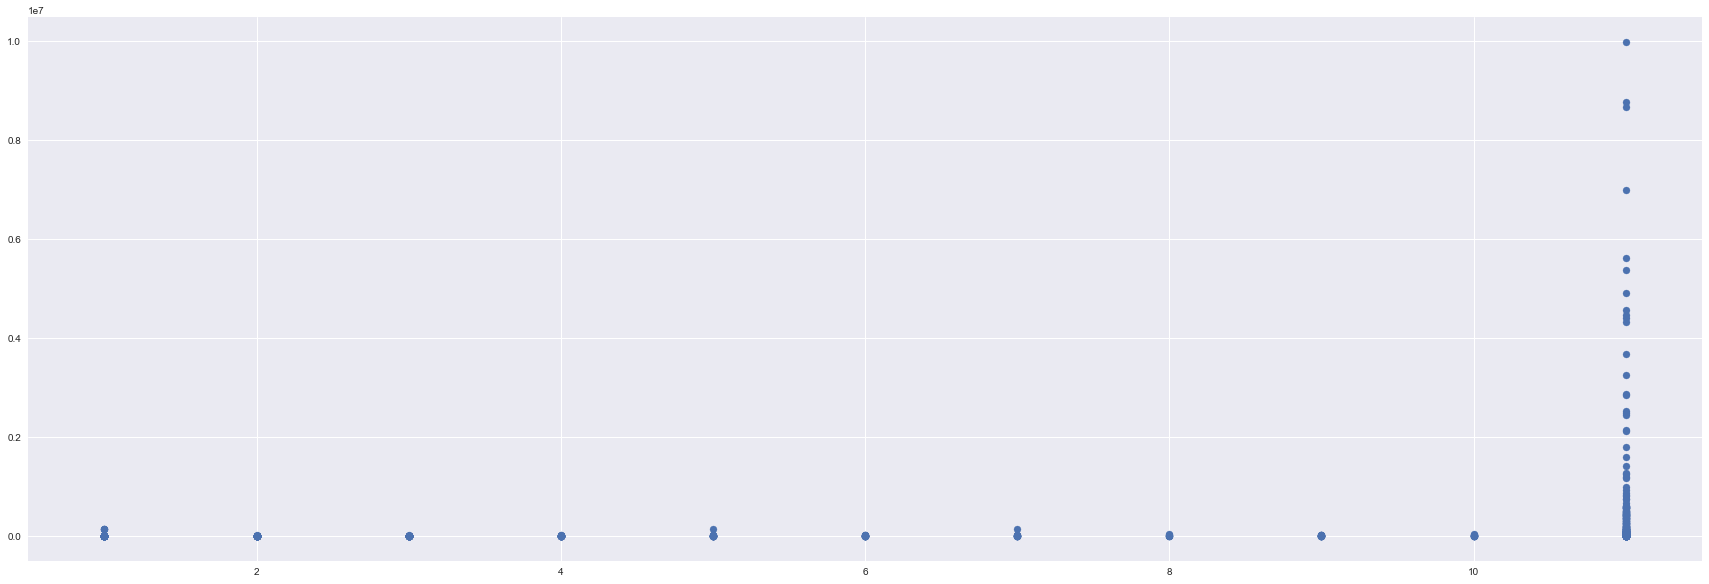

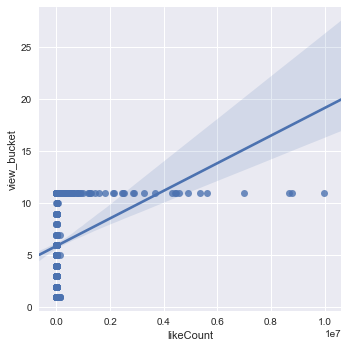

In [11]:
# Dependence test on continuous data

from scipy.stats import spearmanr

plt.scatter(df['view_bucket'], df['likeCount'])
sns.lmplot(x='likeCount', y='view_bucket', data=df)

coef, p = spearmanr(df['likeCount'], df['view_bucket'])

print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('LikeCount and views are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('LikeCount and views are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.142
Snippet tag lengths and views are correlated (reject H0) p=0.000


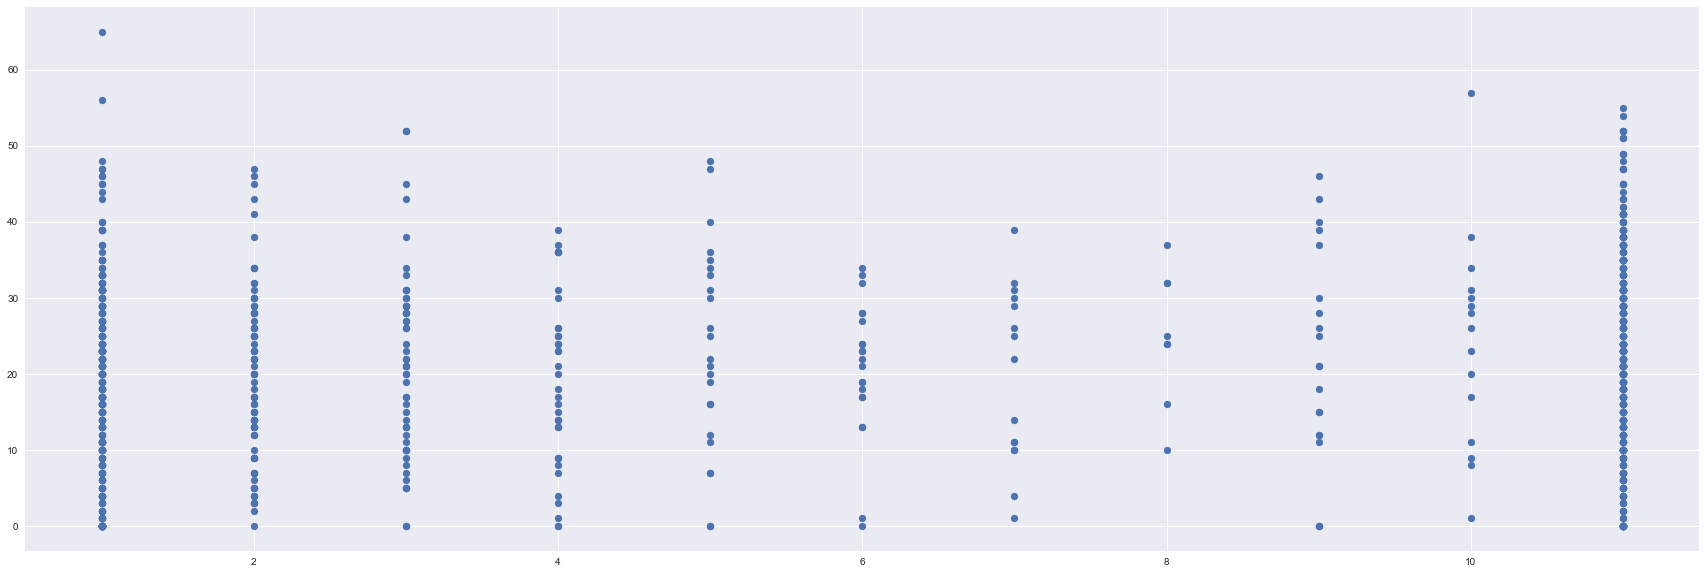

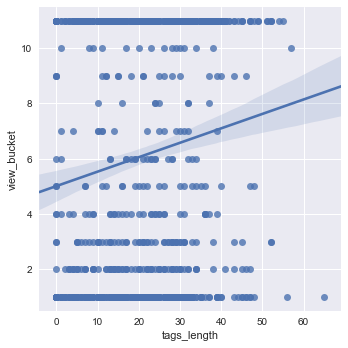

In [12]:
# Dependence test on continuous data

from scipy.stats import spearmanr

plt.scatter(df['view_bucket'], df['tags_length'])
sns.lmplot(x='tags_length', y='view_bucket', data=df)

coef, p = spearmanr(df['tags_length'], df['view_bucket'])

print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Snippet tag lengths and views are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Snippet tag lengths and views are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.887
Samples are correlated (reject H0) p=0.000


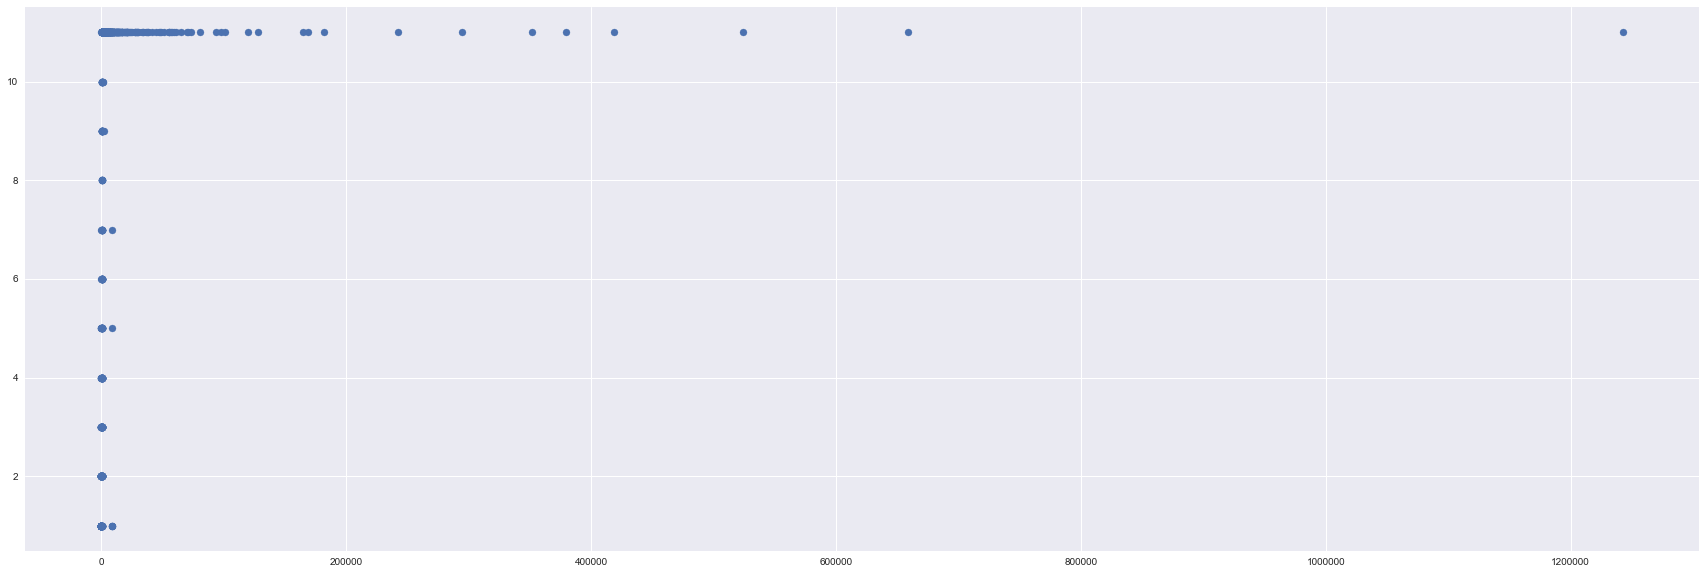

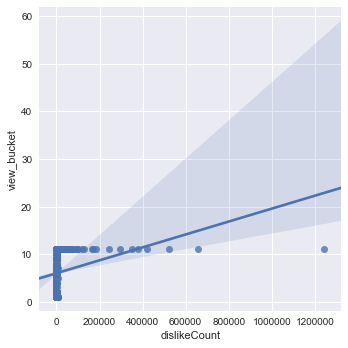

In [13]:
plt.scatter(df['dislikeCount'], df['view_bucket'])
sns.lmplot(x='dislikeCount', y='view_bucket', data=df)

coef, p = spearmanr(df['dislikeCount'], df['view_bucket'])

print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.707
Comment count and views are correlated (reject H0) p=0.000


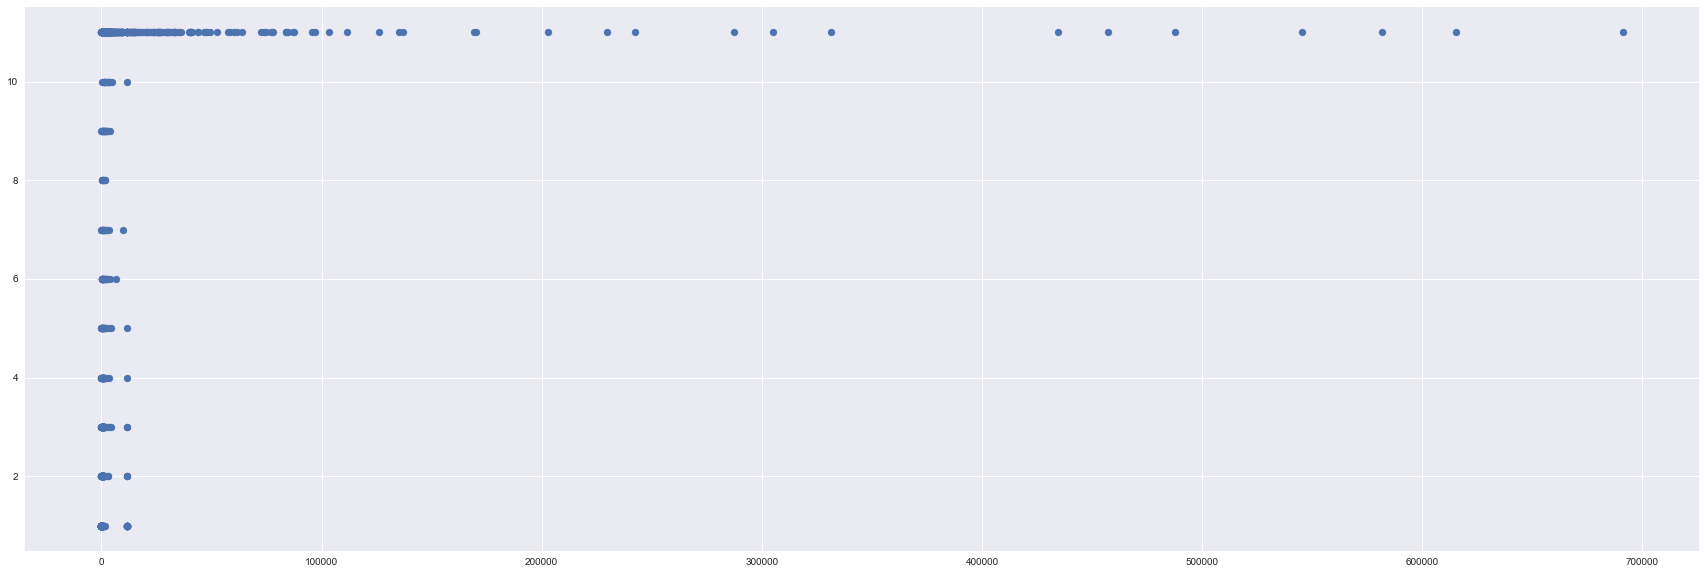

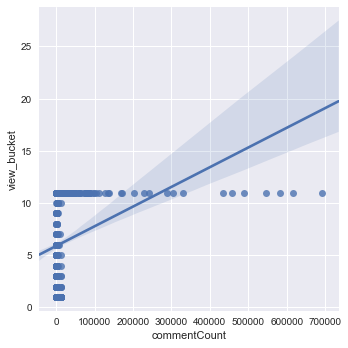

In [14]:
plt.scatter(df['commentCount'], df['view_bucket'])
sns.lmplot(x='commentCount', y='view_bucket', data=df)

coef, p = spearmanr(df['commentCount'], df['view_bucket'])

print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Comment count and views are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Comment count and views are correlated (reject H0) p=%.3f' % p)